In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## 1. Data Exploration

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

## 2. EDA

### Target

In [45]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

#### The target is a little imbalanced

### Keywords

In [10]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

#### Keyword looks like a useful feature bc includes a lot of words about disaster. Let's look closer

In [56]:
train['keyword'] = train['keyword'].fillna('Unknown')
test['keyword'] = test['keyword'].fillna('Unknown')

top_keywords = train['keyword'].value_counts().index[:10]
top_keywords

Index(['Unknown', 'fatalities', 'deluge', 'armageddon', 'sinking', 'damage',
       'harm', 'body%20bags', 'evacuate', 'fear'],
      dtype='object', name='keyword')

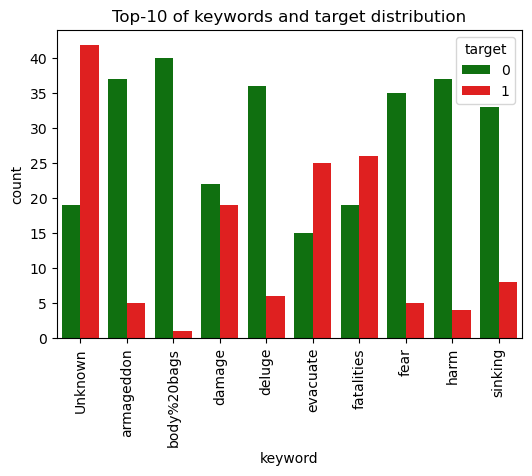

In [13]:
train_top_keywords = train[train['keyword'].isin(top_keywords)]

palette = {0: 'green', 1: 'red'}

plt.figure(figsize=(6, 4))
sns.countplot(data=train_top_keywords, x='keyword', hue='target', palette = palette)
plt.xticks(rotation=90)
plt.title('Top-10 of keywords and target distribution')
plt.show()

#### As we can see words that looks like a disaster are often used for non-disaster tweets. So it's not as easy as looks.
#### Let's look top-10 disaster and non-disaster keywords.

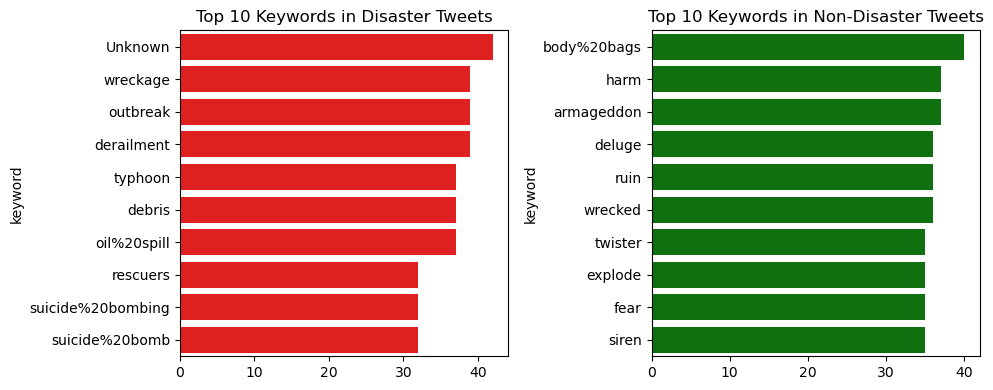

In [15]:
top_disaster_keywords = train[train['target'] == 1]['keyword'].value_counts().head(10)
top_nondisaster_keywords = train[train['target'] == 0]['keyword'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(y=top_disaster_keywords.index, x=top_disaster_keywords.values, ax=axes[0], color = 'red')
axes[0].set_title('Top 10 Keywords in Disaster Tweets')
sns.barplot(y=top_nondisaster_keywords.index, x=top_nondisaster_keywords.values, ax=axes[1], color = 'green')
axes[1].set_title('Top 10 Keywords in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

#### We have different words in each of top-10 that's mean keywords are useful in some way

### Location

In [18]:
train['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

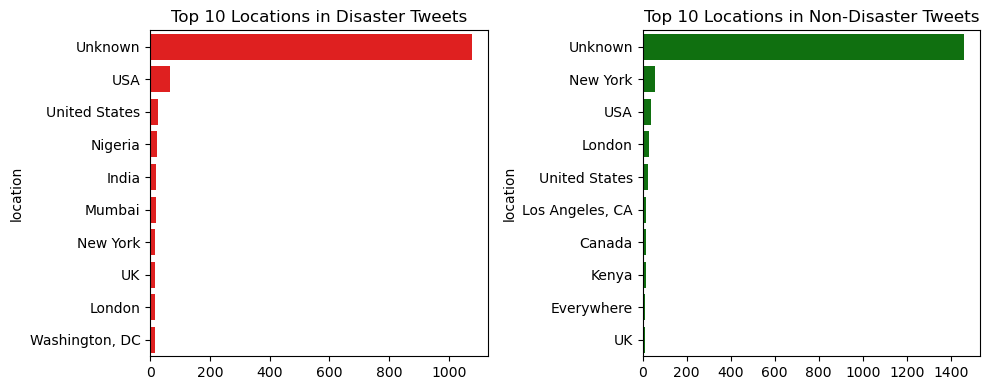

In [19]:
train['location'] = train['location'].fillna('Unknown')

top_disaster_locations = train[train['target'] == 1]['location'].value_counts().head(10)
top_nondisaster_locations = train[train['target'] == 0]['location'].value_counts().head(10)

# Plotting the top locations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(y=top_disaster_locations.index, x=top_disaster_locations.values, ax=axes[0], color='red')
axes[0].set_title('Top 10 Locations in Disaster Tweets')
sns.barplot(y=top_nondisaster_locations.index, x=top_nondisaster_locations.values, ax=axes[1], color='green')
axes[1].set_title('Top 10 Locations in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

#### Locations are not as useful as keywords. I guess we can drop it.

In [21]:
train.drop(columns=['id', 'location'], inplace=True, axis=1)
test.drop(columns=['location'], inplace=True)

train.head(2)

,keyword,text,target
0,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,Unknown,Forest fire near La Ronge Sask. Canada,1


In [52]:
train.isna().sum()

keyword    0
text       0
target     0
dtype: int64

In [58]:
test.isna().sum()

id         0
keyword    0
text       0
dtype: int64

## 3. Feature Engeneering